# ===== Setup =====

In [ ]:
import os, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import backend as K

# Paths
MODEL_PATH, SCALER_PATH = "pmv_prediction_dnn.keras", "preprocessor.pkl"
OUTPUT_CSV = "optimal_setpoints_dataset2.csv"

# Fixed
FIXED = {"Met": 1.2, "Clo": 0.5, "Building type": "Office", "Climate": "Hot-summer Mediterranean"}

# Grids
V_AIR = np.round(np.arange(0.0, 1.6 + 1e-9, 0.1), 2)
RH = np.arange(40, 61, 2)
T_MONTHLY = np.round(np.arange(10.0, 45.0 + 1e-9, 0.5), 1)
SEASONS = ["Summer", "Winter", "Spring", "Autumn"]
T_SETPOINTS = np.round(np.arange(15.0, 27.0 + 1e-9, 0.5), 1)
PMV_TARGET = 0.0


# ===== Load Model & Preprocessor =====

In [ ]:
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

model = keras.models.load_model(
    MODEL_PATH, custom_objects={"coeff_determination": coeff_determination}, compile=False
)
preprocessor = joblib.load(SCALER_PATH)
print("[info] Loaded artifacts")


[info] Loaded artifacts


# ===== Prediction Helpers =====

In [ ]:
def make_row(state, t_set):
    return pd.DataFrame([{
        "Clo": FIXED["Clo"], "Met": FIXED["Met"],
        "Air temperature (C)": float(t_set),
        "Relative humidity (%)": float(state["rh"]),
        "Air velocity (m/s)": float(state["v_air"]),
        "Outdoor monthly air temperature (C)": float(state["t_monthly"]),
        "Season": str(state["season"]),
        "Building type": FIXED["Building type"],
        "Climate": FIXED["Climate"],
    }])

def predict_pmv(state, t_set):
    X = preprocessor.transform(make_row(state, t_set))
    return float(model.predict(X, verbose=0).ravel()[0])


# ===== Greedy Controller =====

In [ ]:
def greedy_action(state, target=PMV_TARGET):
    best_a, best_err, best_pmv = None, 1e9, None
    for a in T_SETPOINTS:
        pmv = predict_pmv(state, a)
        err = abs(pmv - target)
        if err < best_err:
            best_a, best_err, best_pmv = float(a), err, pmv
    return best_a, best_pmv

# Demo
demo = {"v_air": 0.1, "rh": 60, "t_monthly": 40, "season": "Summer"}
print("[demo]", greedy_action(demo))


[demo] (24.0, 0.06561414897441864)


# ===== Generate CSV =====

In [ ]:
def iter_states():
    for v in V_AIR:
        for h in RH:
            for tm in T_MONTHLY:
                for s in SEASONS:
                    yield {"v_air": float(v), "rh": float(h), "t_monthly": float(tm), "season": s}

def generate_csv(output=OUTPUT_CSV):
    rows = []
    for st in iter_states():
        best_a, best_pmv = greedy_action(st)
        rows.append({**st, "optimal_t_set": best_a, "pmv_hat": best_pmv})
    pd.DataFrame(rows).to_csv(output, index=False)
    print(f"[done] Wrote {len(rows):,} rows to {output}")

# Run once
generate_csv()


# ===== Reward vs Temp =====

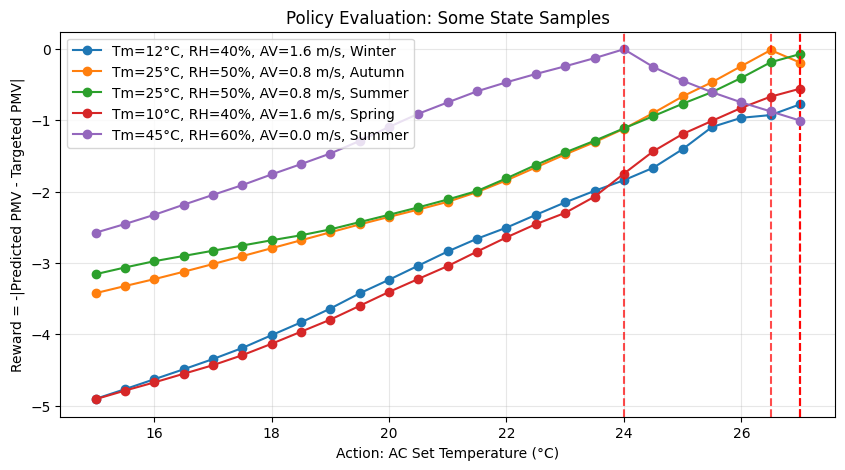

In [ ]:
def reward(pmv, target=PMV_TARGET, squared=False):
    e = pmv - target
    return -(e*e) if squared else -abs(e)

def plot_reward_vs_temp(states, target=PMV_TARGET, squared=False):
    plt.figure(figsize=(10,5))
    for st in states:
        rewards, pmvs = [], []
        for a in T_SETPOINTS:
            pmv_hat = predict_pmv(st, a)
            rewards.append(reward(pmv_hat, target, squared))
            pmvs.append((a, pmv_hat))
        # optimal line
        opt_a, _ = greedy_action(st, target)
        label = f"Tm={st['t_monthly']}°C, RH={st['rh']}%, AV={st['v_air']} m/s, {st['season']}"
        plt.plot(T_SETPOINTS, rewards, marker="o", label=label)
        plt.axvline(opt_a, color="red", linestyle="--", alpha=0.7)  # ✅ optimal vertical line

    plt.xlabel("Action: AC Set Temperature (°C)")
    plt.ylabel("Reward = -|Predicted PMV - Targeted PMV|")
    plt.title("Policy Evaluation: Some State Samples")
    plt.legend(loc="best"); plt.grid(True, alpha=0.3)
    plt.show()

# Example
states_demo = [
    {"v_air": 1.6, "rh": 40, "t_monthly": 12, "season": "Winter"},
    {"v_air": 0.8, "rh": 50, "t_monthly": 25, "season": "Autumn"},
    {"v_air": 0.8, "rh": 50, "t_monthly": 25, "season": "Summer"},
    {"v_air": 1.6, "rh": 40, "t_monthly": 10, "season": "Spring"},
    {"v_air": 0.0, "rh": 60, "t_monthly": 45, "season": "Summer"},
]
plot_reward_vs_temp(states_demo)


# ===== 3D Pair Plots =====

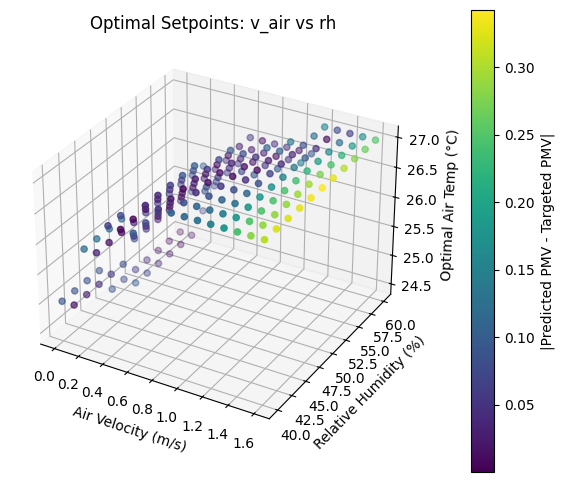

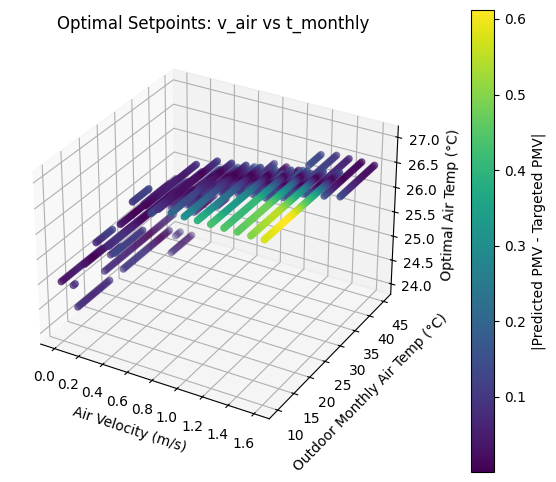

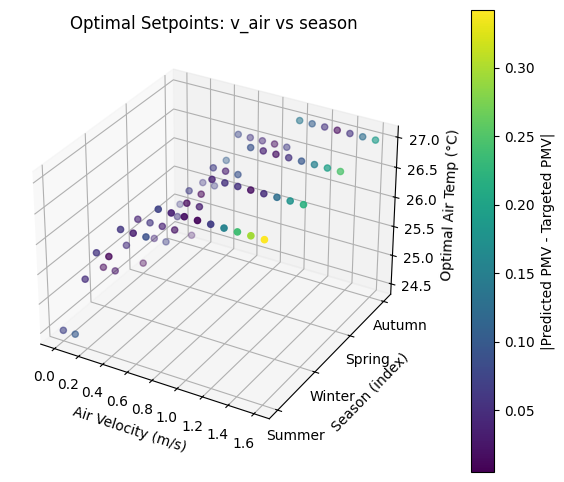

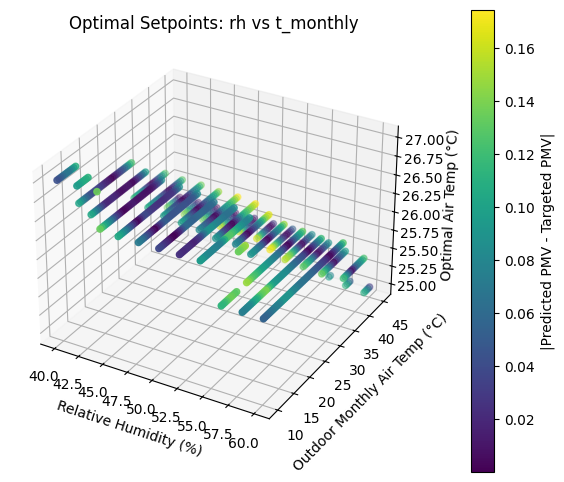

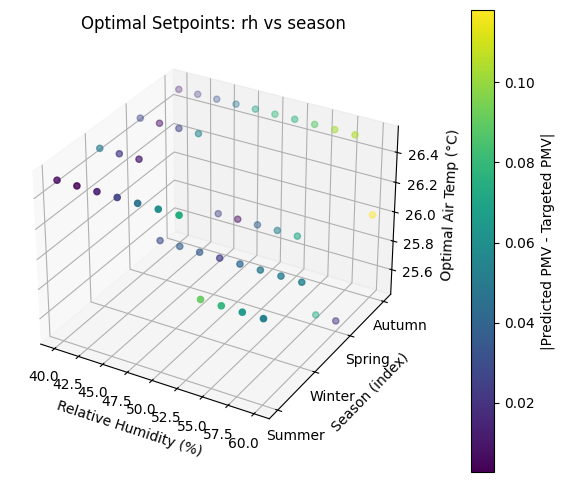

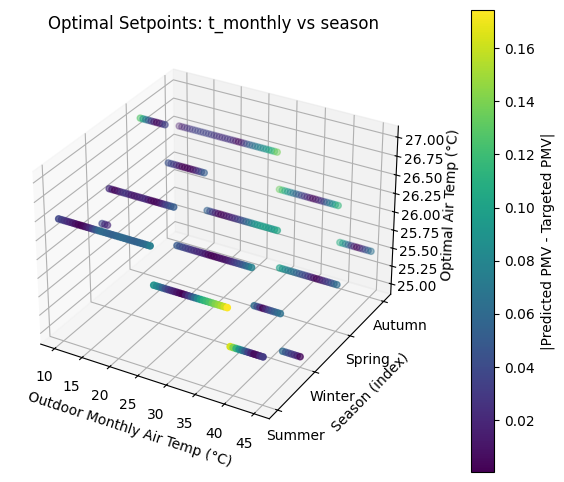

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Pairs of features to plot
PAIR_FEATURES = [
    ("v_air", "rh"),
    ("v_air", "t_monthly"),
    ("v_air", "season"),
    ("rh", "t_monthly"),
    ("rh", "season"),
    ("t_monthly", "season"),
]

# Season encoding
SEASON_TO_NUM = {s: i for i, s in enumerate(SEASONS)}
NUM_TO_SEASON = {i: s for s, i in SEASON_TO_NUM.items()}

def axis_label(name):
    return {
        "v_air": "Air Velocity (m/s)",
        "rh": "Relative Humidity (%)",
        "t_monthly": "Outdoor Monthly Air Temp (°C)",
        "season": "Season (index)",
    }[name]

def build_states(fx, fy, fixed):
    # Pick appropriate grid for each feature
    grid = {"v_air": V_AIR, "rh": RH, "t_monthly": T_MONTHLY, "season": SEASONS}
    Xs, Ys = grid[fx], grid[fy]

    states = []
    for x in Xs:
        for y in Ys:
            st = dict(fixed)
            st[fx] = x
            st[fy] = y
            states.append(st)
    return states

def plot_3d_pair(fx, fy, fixed):
    states = build_states(fx, fy, fixed)
    xs, ys, zs, cs = [], [], [], []

    for st in states:
        best_a, best_pmv = greedy_action(st)
        xs.append(st[fx] if fx != "season" else SEASON_TO_NUM[st[fx]])
        ys.append(st[fy] if fy != "season" else SEASON_TO_NUM[st[fy]])
        zs.append(best_a)
        cs.append(abs(best_pmv))  # |PMV| as color

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(xs, ys, zs, c=cs, cmap="viridis")
    cb = fig.colorbar(sc, pad=0.1); cb.set_label("|Predicted PMV - Targeted PMV|")

    ax.set_xlabel(axis_label(fx))
    ax.set_ylabel(axis_label(fy))
    ax.set_zlabel("Optimal Air Temp (°C)")

    if fx == "season":
        ax.set_xticks(list(NUM_TO_SEASON.keys()))
        ax.set_xticklabels([NUM_TO_SEASON[i] for i in NUM_TO_SEASON])
    if fy == "season":
        ax.set_yticks(list(NUM_TO_SEASON.keys()))
        ax.set_yticklabels([NUM_TO_SEASON[i] for i in NUM_TO_SEASON])

    ax.set_title(f"Optimal Setpoints: {fx} vs {fy}")
    plt.show()

def plot_all_3d_pairs(fixed=None):
    if fixed is None:
        fixed = {"v_air": 0.5, "rh": 50, "t_monthly": 25, "season": "Summer"}
    for fx, fy in PAIR_FEATURES:
        plot_3d_pair(fx, fy, fixed)

# Example: plot all six
plot_all_3d_pairs()
